In [ ]:
!pip install optuna
!pip install pybaseball

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pybaseball as pb
import optuna

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import log_loss, accuracy_score 

In [3]:
# downloading 3 months of pitching data
df = pb.statcast(start_dt = '2023-05-01', end_dt = '2023-08-01')

# dropping pitches that have are of a null type
df = df.dropna(subset = ['pitch_type'])

# resetting the index here for model preparation
df = df.reset_index(drop = True)

This is a large query, it may take a moment to complete


/opt/anaconda3/lib/python3.12/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/93 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = 

## Plotting to understand our data

In [14]:
# we want to subset to a smaller amount of data
# we are going to limit our dataset to 10_000 rows w/ 4 pitch types and right-handed pitchers
df_plt = (df.loc[(df['pitch_type']
                  .isin(['FF', 'SL', 'CU', 'CH'])) & (df['p_throws'] == 'R')]
            .sample(10_000))

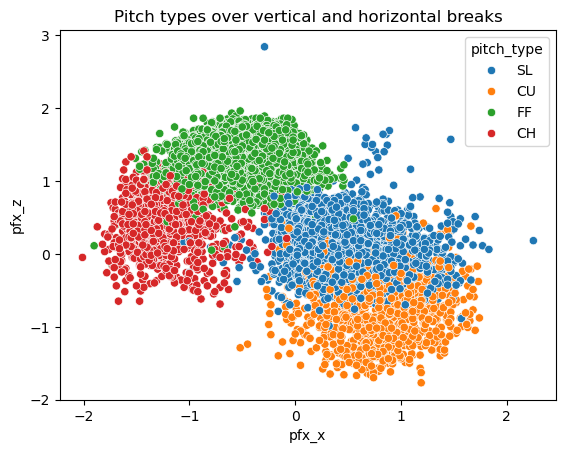

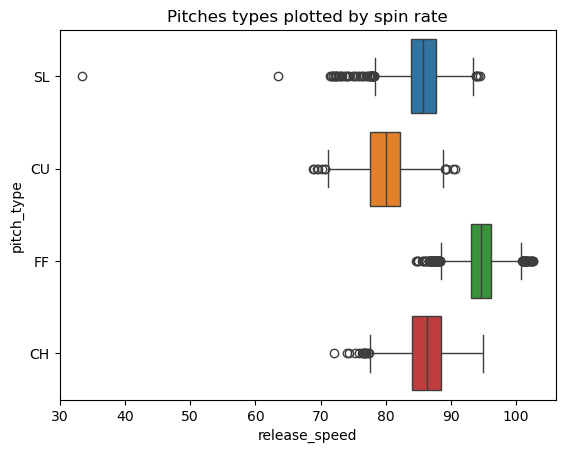

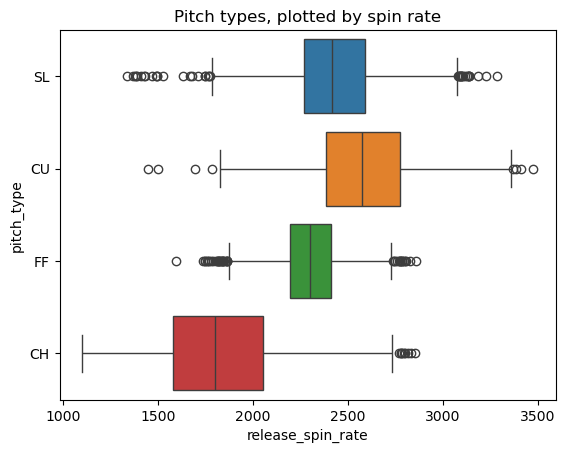

In [16]:
# let's make a few plots now to understand our data sample better and the pitches that we are going to explore

# plotting the "breaks" of our pitches
sns.scatterplot(data = df_plt, x = 'pfx_x', y = 'pfx_z', hue = 'pitch_type')
plt.title('Pitch types over vertical and horizontal breaks')
plt.show()

# plotting the speeds of our pitches
sns.boxplot(data = df_plt, x = 'release_speed', y = 'pitch_type', hue = 'pitch_type')
plt.title('Pitches types plotted by spin rate')
plt.show()

# plotting the spin rates of our pitches
sns.boxplot(data = df_plt, x = 'release_spin_rate', y = 'pitch_type', hue = 'pitch_type')
plt.title('Pitch types, plotted by spin rate')
plt.show()

_Vizualization 1 Insights_
- The horizontal and vertical breaks indicate intent: For example, the tighter clustering of fastballs (FF) with less break (more concentrated on the bottom-right) shows that fastballs are thrown with the goal of maintaining a straight trajectory with minimal deviation.
- In contrast, curveballs (CU) and sliders (SL) have larger deviations, allowing pitchers to get batters to chase pitches out of the zone.

_Vizualization 2 Insights_
- Changeups (CH) act as deceptive off-speed pitches, thrown with a similar arm action as fastballs but with reduced velocity. This speed differential confuses hitters who are timing fastballs, leading to late or mistimed swings.
- Curveballs (CU) prioritize movement over speed, which is why they sit in a moderate speed range — allowing them to generate horizontal and vertical break for inducing weak contact.

_Vizualization 3 Insights_
- Higher spin rates on fastballs (FF) lead to perceived "rising" effect, where the ball resists gravity longer, often resulting in swings and misses, especially at the top of the zone. This is why pitchers with high-spin fastballs can excel in strikeout situations.
- Lower spin on changeups (CH) helps them "fall off the table", creating a tumbling effect that mimics a fastball but with unexpected late drop. This is crucial in disrupting a hitter’s timing and generating weak contact.

These visualizations suggest that pitch classification can be effectively done using break profiles, spin rates, and release speeds, as these features show clear distinctions between pitch types. The clear separation in clusters indicate that our model has strong potential for accurately classifying pitch types. So, let's begin!

## Feature selection

In [28]:
df['pitch_type_code'] = 0

# let's determine wehther a pitcher is right or left handed
# helps us distinguish between break profiles of the pitchers
df['is_lefty'] = 0
df.loc[df['p_throws'] == 'L', 'is_lefty'] = 1

# we can now define our features (spin, speed, break) and our target (pitch types)
# including a few ids will help us navigate and explore our results
id_feats = ['player_name', 'pitcher', 'pitch_type']
feats = ['is_lefty', 'release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z']
target = 'pitch_type_code'

# drop any null values
# let's also eliminate knuckleballs as they don't occur too often nowadays and might lead to errors in our model
subset = df.loc[df['pitch_type']!='KN', id_feats+feats+[target]].dropna()

# let's turn our pitch types into numerical values 
subset['pitch_type_code'] = subset['pitch_type'].astype('category').cat.codes

# let's split our data into a train and test set
# we want 100_000 pitches in the train set and 50_000 pitches in the test settest = subset.sample(50000)
test = subset.sample(50000)
train = subset.loc[~subset.index.isin(test.index.values)].sample(100000)

subset

,player_name,pitcher,pitch_type,is_lefty,release_speed,release_spin_rate,pfx_x,pfx_z,pitch_type_code
0,"Williams, Devin",642207,FF,0,94.4,2175,-0.86,1.29,6
1,"Williams, Devin",642207,CH,0,83.7,2576,-1.68,-0.31,0
2,"Williams, Devin",642207,FC,0,92.9,2276,-0.31,1.35,5
3,"Williams, Devin",642207,FF,0,93.7,2257,-0.84,1.39,6
4,"Williams, Devin",642207,FF,0,93.0,2255,-0.86,1.25,6
...,...,...,...,...,...,...,...,...,...
348738,"Gonsolin, Tony",664062,FF,0,90.9,2183,-0.98,1.41,6
348739,"Gonsolin, Tony",664062,FS,0,82.3,1495,-1.29,0.25,8
348740,"Gonsolin, Tony",664062,SL,0,86.2,2277,0.18,0.8,13
348741,"Gonsolin, Tony",664062,FF,0,91.0,2209,-0.52,1.39,6


In [30]:
# in order to know what pitch types are what, let's create a mapping system 
# so we can change the coded pitches back to the pitch type names 
map_pitch_types = (subset
                   .loc[:, ['pitch_type', 'pitch_type_code']]
                   .drop_duplicates()
                   .set_index('pitch_type_code')
                   .to_dict()['pitch_type'])

# list all the unique pitch type names 
pitch_types = subset['pitch_type'].unique()

# print the pitch type names alongside the pitch codes 
subset.loc[:, ['pitch_type', 'pitch_type_code']].drop_duplicates().sort_values('pitch_type_code')

,pitch_type,pitch_type_code
1,CH,0
49532,CS,1
93,CU,2
10625,EP,3
2183,FA,4
2,FC,5
0,FF,6
21057,FO,7
36,FS,8
320,KC,9


## Logistic regression model

In [ ]:
# let's start off easy and use a logistic regression to classify our pitch types
# train a logistic regression 
logr = LogisticRegression()

# let's fit our model with our defined features and target
logr.fit(train.loc[:, feats], train[target])

# let's predict probabilities of each pitch type and assign it to a df
_df = (pd
       .DataFrame(logr.predict_proba(test.loc[:, feats]), 
                  index=test.index)
       .rename(columns=map_pitch_types)) # this helps us discuss findings using actual pitch types and not their numerical values

# appending the data back to the test dataset 
test = pd.concat([test,_df], axis=1)

# using the highest probability pitch type as the estimated pitch type 
test['pitch_type_pred'] = test.loc[:, pitch_types].idxmax(axis=1)

In [34]:
# producing a sample of our results to see if the predictions were successful
test.sample(10)

,player_name,pitcher,pitch_type,is_lefty,release_speed,release_spin_rate,pfx_x,pfx_z,pitch_type_code,CH,CS,CU,EP,FA,FC,FF,FO,FS,KC,PO,SC,SI,SL,ST,SV,pitch_type_pred
128424,"Irvin, Jake",663623,FF,0,96.6,2413,-0.97,1.27,6,0.071517,3.640617e-95,0.017519,0.001174,0.001161,0.085575,0.484915,1.071701e-10,0.015586,0.022539,8.261596e-93,7.852487e-76,0.176310,0.091987,0.027901,0.003816,FF
174785,"Cordero, Jimmy",622772,SI,0,98.7,2314,-0.97,1.17,12,0.115172,1.570295e-91,0.004886,0.000911,0.000902,0.043748,0.531711,1.672162e-10,0.018236,0.012174,2.857122e-89,5.480021e-73,0.227179,0.032291,0.010123,0.002667,FF
175891,"Bido, Osvaldo",674370,FC,0,85.3,2226,0.2,0.77,5,0.051288,7.933583e-88,0.044281,0.002043,0.002021,0.124654,0.358771,6.414762e-10,0.016010,0.036427,1.181226e-85,5.415137e-70,0.131816,0.169597,0.056809,0.006284,FF
260435,"Mayza, Tim",641835,SI,1,93.1,2080,1.34,0.58,12,0.158824,1.369720e-82,0.002553,0.001077,0.001067,0.029496,0.495907,9.713892e-10,0.023002,0.009343,1.474214e-80,6.395831e-66,0.252676,0.017327,0.006011,0.002717,FF
216095,"Martin, Chris",455119,ST,0,84.0,2529,1.42,-0.38,14,0.004299,9.881494e-100,0.175902,0.000750,0.000740,0.134280,0.072434,2.858507e-11,0.002585,0.033312,2.896828e-97,1.785873e-79,0.018553,0.427429,0.126680,0.003034,SL
38846,"Rodríguez, Yerry",666720,FF,0,96.4,2367,-1.04,0.76,6,0.084023,2.000505e-93,0.013006,0.001169,0.001156,0.073509,0.499360,1.466440e-10,0.016993,0.019899,4.095510e-91,1.849257e-74,0.193587,0.071574,0.022068,0.003659,FF
1469,"Sandoval, Patrick",663776,FF,1,94.3,1797,0.56,1.36,6,0.289165,3.247183e-72,0.000128,0.000495,0.000492,0.004968,0.394298,3.200376e-09,0.022728,0.001835,1.856168e-70,8.275709e-58,0.283086,0.001325,0.000514,0.000967,FF
288143,"Luzardo, Jesús",666200,FF,1,94.6,2126,1.15,1.03,6,0.151963,2.298220e-84,0.002618,0.001002,0.000993,0.030184,0.506440,6.623301e-10,0.021844,0.009306,2.742797e-82,2.506698e-67,0.248847,0.018064,0.006144,0.002593,FF
237095,"Wells, Tyler",669330,CH,0,84.8,2252,-1.59,1.34,0,0.041643,7.996842e-89,0.055107,0.001983,0.001961,0.134170,0.326659,5.185049e-10,0.014064,0.038629,1.261787e-86,8.806948e-71,0.114279,0.198902,0.066341,0.006261,FF
25732,"Heaney, Andrew",571760,CH,1,84.1,2022,1.56,0.52,0,0.109120,4.533819e-80,0.013356,0.002197,0.002177,0.070873,0.454558,2.821566e-09,0.024969,0.023178,4.275406e-78,7.221000e-64,0.208308,0.062743,0.022784,0.005736,FF


In [37]:
# producing accuracy and log loss metrics to evaluate our model's performance 
acc = accuracy_score(test['pitch_type'], test.loc[:, 'pitch_type_pred'])
loss = log_loss(test['pitch_type'], test.loc[:, pitch_types])
acc, loss

(0.4489, 9.369123779718942)

The logistic regression classifier produced an accuracy of 44.9% with a log loss of 9.37. We know that some of features are non linear, such as break, so it is possible that a linear model (like log regression) might have had a tough time handling the non-linear features. 

Let's try a different non-linear model, like random forest, and see how our model performs.

## Random forest classifier

In [41]:
# dropping our old predictions
test = test.drop(pitch_types, axis=1)

In [43]:
# using a random forest model
rf = RandomForestClassifier()
rf.fit(train.loc[:, feats], train[target])
_df = (pd
       .DataFrame(rf.predict_proba(test.loc[:, feats]), 
                  index=test.index)
       .rename(columns=map_pitch_types))

test = pd.concat([test,_df], axis=1)
test['pitch_type_pred'] = test.loc[:, pitch_types].idxmax(axis=1)

In [44]:
test.sample(10)

,player_name,pitcher,pitch_type,is_lefty,release_speed,release_spin_rate,pfx_x,pfx_z,pitch_type_code,pitch_type_pred,CH,CS,CU,EP,FA,FC,FF,FO,FS,KC,PO,SC,SI,SL,ST,SV
146617,"Williams, Trevor",592866,SL,0,80.6,2076,0.61,0.29,13,SL,0.00,0.0,0.01,0.0,0.0,0.00,0.00,0.0,0.00,0.01,0.0,0.0,0.00,0.84,0.14,0.00
298701,"Heaney, Andrew",571760,SL,1,80.4,2639,-1.25,-0.43,13,SL,0.01,0.0,0.23,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.49,0.26,0.01
285762,"Burnes, Corbin",669203,FC,0,95.5,2722,0.34,1.19,5,FC,0.00,0.0,0.00,0.0,0.0,0.93,0.07,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00
170085,"Blackburn, Paul",621112,SI,0,91.6,1991,-1.27,0.77,12,SI,0.02,0.0,0.00,0.0,0.0,0.00,0.01,0.0,0.00,0.00,0.0,0.0,0.97,0.00,0.00,0.00
166257,"Garrett, Reed",657585,FF,0,95.5,2318,-0.53,1.29,6,FF,0.00,0.0,0.00,0.0,0.0,0.00,0.98,0.0,0.00,0.00,0.0,0.0,0.02,0.00,0.00,0.00
260187,"Kelly, Joe",523260,CH,0,87.1,2101,-1.58,0.46,0,CH,0.91,0.0,0.00,0.0,0.0,0.00,0.02,0.0,0.01,0.00,0.0,0.0,0.06,0.00,0.00,0.00
283480,"Nelson, Ryne",669194,FF,0,95.9,2239,-0.04,1.57,6,FF,0.00,0.0,0.00,0.0,0.0,0.00,1.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00
150501,"Beck, Tristan",663941,FF,0,93.6,1813,-0.81,1.22,6,FF,0.01,0.0,0.00,0.0,0.0,0.00,0.98,0.0,0.00,0.00,0.0,0.0,0.01,0.00,0.00,0.00
323702,"Wesneski, Hayden",669713,FF,0,95.7,2261,-0.54,1.04,6,FF,0.00,0.0,0.00,0.0,0.0,0.00,0.99,0.0,0.00,0.00,0.0,0.0,0.01,0.00,0.00,0.00
330602,"Bassitt, Chris",605135,FC,0,85.6,2046,0.21,0.55,5,SL,0.01,0.0,0.00,0.0,0.0,0.31,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.68,0.00,0.00


We can immediately see that we have a lot more definitive predictions and values compared to earlier with our logistic regression model.

In [48]:
acc = accuracy_score(test['pitch_type'], test.loc[:, 'pitch_type_pred'])
loss = log_loss(test['pitch_type'], test.loc[:, pitch_types])
acc, loss

(0.82556, 34.92040355896551)

We can see that the random forest model is a clear improvement in accuracy over our previous logistic regression model. Although the log loss is greater (worse), i.e. we were really wrong when we our predicted probabilities were incorrect, the accuracy is still significantly better. 

The loss may have occurred due to the classification being much stronger for a wrong pitch type. For example, someone's curveball might have been classified as a slider, or vice-versa. Let's combat this by exploring and using optuna to improve our accuracy even further by tuning our features and model.

## Optuna exploration

In [54]:
# dropping our old predictions
test = test.drop(pitch_types, axis=1)

In [56]:
# defining our optuna function
def tune(trial):
    n_estimators=trial.suggest_int('n_estimators', 10, 500)
    max_features=trial.suggest_categorical('max_features', ["sqrt", "log2"])

    # using the same code from earlier to fit our random forest
    model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features)
    model.fit(train.loc[:, feats], train[target])
    _df = (pd
        .DataFrame(model.predict_proba(test.loc[:, feats]), 
                    index=test.index)
        .rename(columns=map_pitch_types))
    
    _df['pitch_type_pred'] = _df.loc[:, pitch_types].idxmax(axis=1)
    acc = accuracy_score(test['pitch_type'], _df['pitch_type_pred'])
    
    return acc

In [58]:
# as we are using accuracy, we are going to use a direction of maximize
study = optuna.create_study(direction='maximize')
study.optimize(tune, n_trials=3)

[I 2024-11-13 20:50:24,143] A new study created in memory with name: no-name-f4002145-8b2c-4f90-b077-13becc7a7b0e
[I 2024-11-13 20:50:50,530] Trial 0 finished with value: 0.82648 and parameters: {'n_estimators': 231, 'max_features': 'log2'}. Best is trial 0 with value: 0.82648.
[I 2024-11-13 20:50:55,909] Trial 1 finished with value: 0.8244 and parameters: {'n_estimators': 47, 'max_features': 'log2'}. Best is trial 0 with value: 0.82648.
[I 2024-11-13 20:51:48,362] Trial 2 finished with value: 0.8262 and parameters: {'n_estimators': 472, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.82648.


In [60]:
study.best_params

{'n_estimators': 231, 'max_features': 'log2'}

After 3 trials, we can see that our best parameters are 231 estimators, with a max features categorical value of log2.

In [63]:
# now we can run the random forest classifier again and plug in the values of our best parameters
rf = RandomForestClassifier(n_estimators=study.best_params['n_estimators'], 
                            max_features=study.best_params['max_features'])

rf.fit(train.loc[:, feats], train[target])

_df = (pd
       .DataFrame(rf.predict_proba(test.loc[:, feats]), 
                  index=test.index)
       .rename(columns=map_pitch_types))

test = pd.concat([test,_df], axis=1)
test['pitch_type_pred'] = test.loc[:, pitch_types].idxmax(axis=1)

In [65]:
acc = accuracy_score(test['pitch_type'], test.loc[:, 'pitch_type_pred'])
loss = log_loss(test['pitch_type'], test.loc[:, pitch_types])
acc, loss

(0.82582, 34.60383850041769)

The improvement in accuracy is very minimal. However, if we were to choose different parameters to tune over (we only tuned n_estimators and max_features) or if we chose a different model that was more suited to our features (e.g. SVM or GBM) or if we incorporated more features, such as release points, we could improve our model's accuracy even further. 

## Takeaways and improvements

- The clustering in the pitch break chart shows clear separation between pitch types like fastballs (FF) and curveballs (CU). However, some overlap in sliders (SL) and changeups (CH) could be due to pitchers with unique grips or variations in release points.
    - We could improve upon this by incorporating pitcher-specific characteristics (e.g., release height, arm slot) to better distinguish between borderline pitch types. 
-  The inclusion of `is_lefty` helps differentiate the movement profiles, but currently, its impact on predictions could be limited since left-handed pitchers are less frequent in the dataset.
    -  We could adjust for class imbalance by either increasing the sample size for left-handed pitchers or assigning class weights to better reflect their impact on predictions.
-  The box plots highlight that sliders (SL) and curveballs (CU) have the highest spin rates, which is consistent with their breaking action. However, fastballs (FF) with high spin rates are known to generate more "rise" and are often more effective.
    - We could include a feature for spin efficiency or categorize spin rate into bands (e.g., high, medium, low) to capture this nuance.
- With the current dataset split, the model might struggle to generalize due to the fixed sample size approach. This could lead to biases, and ultimately overfitting, if the training set doesn’t accurately represent the full diversity of pitch types.

## Next steps

- We could collect additional data points from previous seasons or include minor league data to enhance the dataset size, particularly for underrepresented pitch types like knuckleballs (KN). This will help improve model generalization and accuracy.
    - We could introduce more features like release_extension and effective_speed to capture nuances in how pitches are perceived by batters.
    - Adding contextual game features, such as pitch count, count leverage, or inning number, could provide richer inputs for the model and help improve its accuracy.
- We could perform hyperparameter tuning (using GridSearchCV or RandomizedSearchCV or SequentialFeatureSelector) to optimize performance. This could significantly improve classification accuracy, especially for pitch types that are difficult to distinguish.
- Players coming back from injuries or with reduced playing time could have definitely skewed results. Introducing an injury indicator or using rolling averages for certain stats could smooth out predictions in the future.